In [1]:
import math as m
import numpy as np
from IPython.display import clear_output
from time import sleep

In [2]:
#select ROI and range of frames of interest:
curDate=r'20230220' #current date
framesSkip = 10
#define borders of the region of interest
leftBorder = 56.0
rightBorder= 440.0
yMin = 120.0
yMax = 1412.0
#start and and frames
iBegin = 180
iEnd =  1168
dY = 30.0 # width of a bin in the histogram
nB = m.floor((yMax - yMin)/dY)
yBins = np.arange(nB) * dY + yMin + dY/2.0
yBins # bins values for the histogram

array([ 135.,  165.,  195.,  225.,  255.,  285.,  315.,  345.,  375.,
        405.,  435.,  465.,  495.,  525.,  555.,  585.,  615.,  645.,
        675.,  705.,  735.,  765.,  795.,  825.,  855.,  885.,  915.,
        945.,  975., 1005., 1035., 1065., 1095., 1125., 1155., 1185.,
       1215., 1245., 1275., 1305., 1335., 1365., 1395.])

In [3]:
# using the cloud-in-cell method, python version:
"""
see line 218 for example_cic()
Note: x value must lie within [0,NX>, i.e. NX = max(x)
# changed by xun: transpose axes, now consistent with input
"""

def standarlize_x(x, nx, xmax=None, xmin=None):
    """
    move x value to [0,nx]
    """
    if xmax==None: xmax = x.max()
    if xmin==None: xmin = x.min()
    x = (x - xmin) /  (xmax - xmin) * nx
    return x

def cic(value, x, nx, y=None, ny=1, z=None, nz=1,
        wraparound=False, average=True):
    """ Interpolate an irregularly sampled field using Cloud in Cell
    method.
    This function interpolates an irregularly sampled field to a
    regular grid using Cloud In Cell (nearest grid point gets weight
    1-dngp, point on other side gets weight dngp, where dngp is the
    distance to the nearest grid point in units of the cell size).
    
    Inputs
    ------
    value: array, shape (N,)
        Sample weights (field values). For a temperature field this
        would be the temperature and the keyword average should be
        True. For a density field this could be either the particle
        mass (average should be False) or the density (average should
        be True).
    x: array, shape (N,)
        X coordinates of field samples, unit indices: [0,NX>.
    nx: int
        Number of grid points in X-direction.
    y: array, shape (N,), optional
        Y coordinates of field samples, unit indices: [0,NY>.
    ny: int, optional
        Number of grid points in Y-direction.
    z: array, shape (N,), optional
        Z coordinates of field samples, unit indices: [0,NZ>.
    nz: int, optional
        Number of grid points in Z-direction.
    wraparound: bool (False)
        If True, then values past the first or last grid point can
        wrap around and contribute to the grid point on the opposite
        side (see the Notes section below).
    average: bool (False)
        If True, average the contributions of each value to a grid
        point instead of summing them.
    Returns
    -------
    dens: ndarray, shape (nx, ny, nz)
        The grid point values.
    Notes
    -----
    Example of default allocation of nearest grid points: nx = 4, * = gridpoint.
      0   1   2   3     Index of gridpoints
      *   *   *   *     Grid points
    |---|---|---|---|   Range allocated to gridpoints ([0.0,1.0> -> 0, etc.)
    0   1   2   3   4   posx
    Example of ngp allocation for wraparound=True: nx = 4, * = gridpoint.
      0   1   2   3        Index of gridpoints
      *   *   *   *        Grid points
    |---|---|---|---|--    Range allocated to gridpoints ([0.5,1.5> -> 1, etc.)
      0   1   2   3   4=0  posx
    References
    ----------
    R.W. Hockney and J.W. Eastwood, Computer Simulations Using Particles
        (New York: McGraw-Hill, 1981).
    Modification History
    --------------------
    IDL code written by Joop Schaye, Feb 1999.
    Avoid integer overflow for large dimensions P.Riley/W.Landsman Dec. 1999
    Translated to Python by Neil Crighton, July 2009.
    
    Examples
    --------
    >>> nx = 20
    >>> ny = 10
    >>> posx = np.random.rand(size=1000)
    >>> posy = np.random.rand(size=1000)
    >>> value = posx**2 + posy**2
    >>> field = cic(value, posx*nx, nx, posy*ny, ny)
    # plot surface
    """

    def findweights(pos, ngrid):
        """ Calculate CIC weights.
        
        Coordinates of nearest grid point (ngp) to each value. """

        if wraparound:
            # grid points at integer values
            ngp = np.fix(pos + 0.5)
        else:
            # grid points are at half-integer values, starting at 0.5,
            # ending at len(grid) - 0.5
            ngp = np.fix(pos) + 0.5

        # Distance from sample to ngp.
        distngp = ngp - pos

        # weight for higher (right, w2) and lower (left, w1) ngp
        weight2 = np.abs(distngp)
        weight1 = 1.0 - weight2

        # indices of the nearest grid points
        if wraparound:
            ind1 = ngp
        else:
            ind1 = ngp - 0.5
        ind1 = ind1.astype(int)

        ind2 = ind1 - 1
        # Correct points where ngp < pos (ngp to the left).
        ind2[distngp < 0] += 2

        # Note that ind2 can be both -1 and ngrid at this point,
        # regardless of wraparound. This is because distngp can be
        # exactly zero.
        bad = (ind2 == -1)
        ind2[bad] = ngrid - 1
        if not wraparound:
            weight2[bad] = 0.
        bad = (ind2 == ngrid)
        ind2[bad] = 0
        if not wraparound:
            weight2[bad] = 0.

        if wraparound:
            ind1[ind1 == ngrid] = 0

        return dict(weight=weight1, ind=ind1), dict(weight=weight2, ind=ind2)


    def update_field_vals(field, totalweight, a, b, c, value, debug=True):
        """ This updates the field array (and the totweight array if
        average is True).
        The elements to update and their values are inferred from
        a,b,c and value.
        """
        print('Updating field vals')
        print(a)
		# indices for field - doesn't include all combinations
        indices = a['ind'] + b['ind'] * nx + c['ind'] * nxny
        # weight per coordinate
        weights = a['weight'] * b['weight'] * c['weight']
        # Don't modify the input value array, just rebind the name.
        value = weights * value 
        if average:
            for i,ind in enumerate(indices):
                field[ind] += value[i]
                totalweight[ind] += weights[i]
        else:
            for i,ind in enumerate(indices):
                field[ind] += value[i]
            #if debug: print ind, weights[i], value[i], field[ind]


    nx, ny, nz = (int(i) for i in (nx, ny, nz))
    nxny = nx * ny
    value = np.asarray(value)

    print('Resampling %i values to a %i by %i by %i grid' % (
        len(value), nx, ny, nz))

    # normalise data such that grid points are at integer positions.
    #x = (x - x.min()) / x.ptp() * nx
    #y = (y - y.min()) / y.ptp() * ny
    #z = (z - z.min()) / z.ptp() * nz

    x1, x2 = findweights(np.asarray(x), nx)
    y1 = z1 = dict(weight=1., ind=0)
    if y is not None:
        y1, y2 = findweights(np.asarray(y), ny)
        if z is not None:
            z1, z2 = findweights(np.asarray(z), nz)

    # float32 to save memory for big arrays (e.g. 256**3)
    field = np.zeros(nx * ny * nz, np.float32)

    if average:
        totalweight = np.zeros(nx * ny * nz, np.float32)
    else:
        totalweight = None

    update_field_vals(field, totalweight, x1, y1, z1, value)
    update_field_vals(field, totalweight, x2, y1, z1, value)
    if y is not None:
        update_field_vals(field, totalweight, x1, y2, z1, value)
        update_field_vals(field, totalweight, x2, y2, z1, value)
        if z is not None:
            update_field_vals(field, totalweight, x1, y1, z2, value)
            update_field_vals(field, totalweight, x2, y1, z2, value)
            update_field_vals(field, totalweight, x1, y2, z2, value)
            update_field_vals(field, totalweight, x2, y2, z2, value)

    if average:
        good = totalweight > 0
        field[good] /= totalweight[good]

    return field.reshape((nx, ny, nz)).squeeze().transpose()

In [4]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

In [5]:
import pandas as pd
from pandas import DataFrame, Series  # for convenience

In [ ]:
mpl.rc('figure',  figsize=(10, 10.0*1412.0/520.0))
mpl.rc('image', cmap='gray')

In [6]:
import pims

In [7]:
import trackpy as tp

In [8]:
frames = pims.open(r'g:\My Drive\workAppState\prj_shocks\expData\data20230207\soliton_240fps_73\analysis\20230220histogPython\02_an_WorkflowTrackPy\inputs\*.tif')
frames

<Frames>
Source: g:\My Drive\workAppState\prj_shocks\expData\data20230207\soliton_240fps_73\analysis\20230220histogPython\02_an_WorkflowTrackPy\inputs\*.tif
Length: 601 frames
Frame Shape: (1412, 520)
Pixel Datatype: uint8

In [9]:
type(frames)

pims.image_sequence.ImageSequence

In [10]:
type(frames[0])

pims.frame.Frame

In [ ]:
fig, ax = plt.subplots()
ax = plt.imshow(frames[0])

In [ ]:
f = tp.locate(frames[0], 3)

In [ ]:
tp.annotate(f, frames[0])

In [ ]:
f.head(20)

In [ ]:
f = tp.locate(frames[233], 7, minmass = 100, separation = 2, threshold = 5)
tp.annotate(f, frames[233])

In [ ]:
f.head()

In [ ]:
f.tail()

In [11]:
f_all = tp.batch(frames[:], 7, minmass = 100, separation = 2, threshold = 5)

Frame 600: 1855 features


In [12]:
def f_check_limited(x, y, frame, frame_begin, frame_end, left, right, maxY, minY):
    if (x <= right and x >= left and y <= maxY and y >= minY 
        and frame >= frame_begin and frame <= frame_end):
        return True
    else:
        return False
    

In [13]:
#vectorize the function f_check_limited, so can apply to arrays:
f_check_if_ROI = np.vectorize(f_check_limited)

In [14]:
ind = f_check_if_ROI(f_all['x'], f_all['y'], f_all['frame'], iBegin, iEnd, leftBorder, rightBorder, yMax, yMin)

In [15]:
f_ROI = f_all[ind]

In [16]:
f_all.tail()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1108759,1405.501453,491.062500,263.576939,1.344671,0.136805,39.076814,751.0,0.093950,600
1108760,1407.045872,45.414373,501.102668,1.385265,0.189344,75.854991,1264.0,0.050389,600
1108761,1408.121406,287.354633,119.912183,1.367117,0.237953,16.473559,581.0,0.131672,600
1108762,1406.368421,295.422172,342.113672,1.379339,0.209813,53.251736,946.0,0.070713,600
1108763,1407.862745,319.526961,156.307254,1.467791,0.240148,19.921513,663.0,0.110308,600


In [17]:
f_ROI.tail()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
1108757,1404.636899,164.244357,390.385030,1.307861,0.103090,64.361811,1135.0,0.057039,600
1108758,1405.405295,233.892057,188.105054,1.567880,0.305076,32.947117,722.0,0.098777,600
1108761,1408.121406,287.354633,119.912183,1.367117,0.237953,16.473559,581.0,0.131672,600
1108762,1406.368421,295.422172,342.113672,1.379339,0.209813,53.251736,946.0,0.070713,600
1108763,1407.862745,319.526961,156.307254,1.467791,0.240148,19.921513,663.0,0.110308,600


In [ ]:
#visual control if we correctly determined ROI:
tp.annotate(f_ROI[f_ROI['frame'] == 233], frames[233])

In [ ]:
    


    weighNumDens = DBLARR(N_ELEMENTS(YforHist))+1 ; weights for the number density
    histNumDens = CIC(weighNumDens, YforHist, nB, /ISOLATED) / dy / (rightBorder - leftBorder)
    maxDen_i=MAX(histNumDens, max_pos_ind_i);
    maxDen = [maxDen,maxDen_i]
    max_pos_i = YBins[max_pos_ind_i]
    max_pos = [max_Pos,max_pos_i]
    timeT = [timeT,i]


    seconds = STRING(SYSTIME(/seconds),FORMAT='(I18)')
    filename = STRCOMPRESS(STRING(i,FORMAT='(I04)') + '.csv', /REMOVE_ALL)
    z=print2arrays(filename,yBins, histNumDens)
    ; also save the particles positions in the frame:
    pixIDLx = Y
    pixIDLy = Xroim[indf]

    ;   thead=STRCOMPRESS('Frame ' + STRING(i,FORMAT='(I04)') + 'particle coordinates in orientation when shock propagates along X axis from left to right')
    ;   colhead = ['pixIDLx','pixIDLy']
    ;   fnamCSV = STRCOMPRESS('partPosPixels_frame'+ STRING(i,FORMAT='(I04)')+ '_' + seconds + '.csv', /REMOVE_ALL)
    ;   WRITE_CSV, fnamCSV, pixIDLx, pixIDLy, HEADER = colhead, TABLE_HEADER = thead

  ENDFOR

In [ ]:
mpl.rc('figure',  figsize=(6, 4))
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

In [ ]:
for i in range(iBegin, iEnd, framesSkip):
    print('frame ', i)
    #building histogram using cloud-in-cell (cic):
    indf = f_ROI['frame'] == i
    f_ROI_i = f_ROI[indf]
    YforHist = (np.array(f_ROI_i['y']) - yMin)/(yMax-yMin + 1.0E-8) * np.double(nB)
    weighNumDens = np.full(len(YforHist), np.double(1), dtype = np.double)
    histNumDens = cic(weighNumDens, YforHist, nB) / dY / (rightBorder - leftBorder)
    clear_output(wait = True)
    ax.cla()
    ax.scatter(yBins, histNumDens)
    sleep(2)
    
    

In [ ]:
weighNumDens = np.full(len(YforHist) + 1, np.double(1), dtype = np.double)

In [ ]:
print(weighNumDens)

In [22]:
indf = f_ROI['frame'] == 233
f_ROI_i = f_ROI[indf]
YforHist = (np.array(f_ROI_i['y']) - yMin)/(yMax-yMin + 1.0E-8) * np.double(nB)
weighNumDens = np.full(len(YforHist), np.double(1), dtype = np.double)
histNumDens = cic(weighNumDens, YforHist, nB) / dY / (rightBorder - leftBorder)
clear_output(wait = True)


Resampling 1442 values to a 43 by 1 by 1 grid
Updating field vals
{'weight': array([0.80263158, 0.78195983, 0.51758519, ..., 0.68420421, 0.65848445,
       0.6538395 ]), 'ind': array([ 2,  5,  6, ..., 42, 42, 42])}
Updating field vals
{'weight': array([0.19736842, 0.21804017, 0.48241481, ..., 0.        , 0.        ,
       0.        ]), 'ind': array([1, 4, 5, ..., 0, 0, 0])}


In [23]:
print(histNumDens)

[0.000000e+00 8.680556e-05 8.680556e-05 0.000000e+00 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05 8.680556e-05
 8.680556e-05 8.680556e-05 8.680556e-05]


In [25]:
print(weighNumDens)

[1. 1. 1. ... 1. 1. 1.]


Resampling 10000 values to a 10 by 1 by 1 grid
Updating field vals
{'weight': array([0.59510652, 0.89758394, 0.90977539, ..., 0.71765801, 0.99161881,
       0.60878167]), 'ind': array([5, 1, 4, ..., 8, 2, 1])}
Updating field vals
{'weight': array([0.40489348, 0.10241606, 0.09022461, ..., 0.28234199, 0.00838119,
       0.39121833]), 'ind': array([4, 2, 3, ..., 9, 3, 0])}


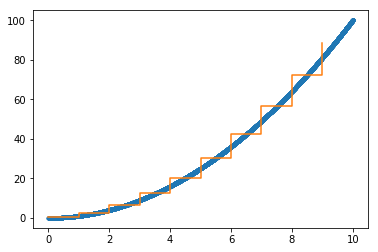

In [29]:
    #from astro.gimic import cic
    # 1d
    import pylab as pl
    x = np.random.rand(10000)*10
    vals = x**2
    pl.figure()
    pl.plot(x, vals, '.')
    field = cic(vals, x, 10)
    pl.plot(np.arange(10), field, ls='steps-post')

In [28]:
print(field)

NameError: name 'field' is not defined